# IMB buoys against TOPAZ ML

In [1]:
# Import buoy
# Import TOPAZ corrected
# Localise TOPAZ daily values to buoy location
# Comparison

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from src.utils import modif_plot

from src.utils import tardisml_utils
rootdir = tardisml_utils.get_rootdir()

## Import buoy

In [4]:
buoy = '2011K'
# irootdir = '/cluster/work/users/leoede/'
irootdir = '/scratch/project_465000269/edelleo1/'
odir = f'{irootdir}Leo/SIT_observations/IMB/{buoy}/'
ofile = f'{buoy}_Mass_Balance_Data.csv'

In [5]:
# buoy to check in 2011: C, J, K

In [6]:
cols = ['date', 'snow depth', 'ice thick', 'topice','botice']
csv_mb = pd.read_csv(f'{odir}{ofile}', header=2,
                      names=cols)

In [7]:
valid_time = csv_mb['date'].notna()  # drop nan at the end of the file
valid_sit = csv_mb['ice thick'].notna()  # drop empty SIT
valid_points = valid_time & valid_sit

sit_dates = csv_mb['date'][valid_points]  # keep only valid
sit_imb = csv_mb['ice thick'][valid_points]


In [8]:
# get lat lon
ofile = f'{buoy}_Position_Data.csv'
cols = ['date', 'latitude', 'longitude']

csv_pos = pd.read_csv(f'{odir}{ofile}', header=2, names=cols)


In [9]:
posi_dates = csv_pos['date']
lat = csv_pos['latitude']
lon = csv_pos['longitude'] 

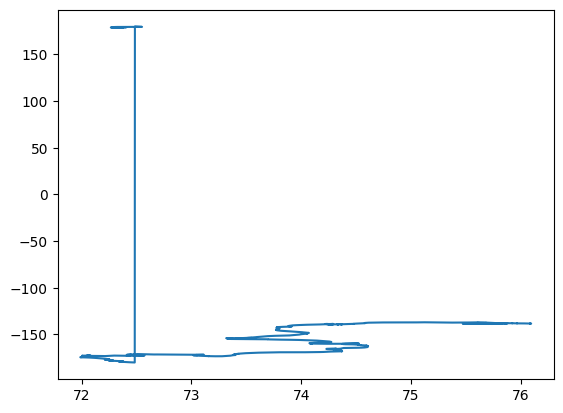

In [10]:
plt.plot(lat, lon)

In [11]:
def clean_latlon(lat):
    '''
    Replace nan by previous valid position (for either latitude or longitude)
    '''
    
    new_lat = []
    
    for ii in range(len(lat)):
        if np.isnan(lat[ii]):
            new_lat.append(new_lat[ii-1])
        else:
            new_lat.append(lat[ii])

    return np.array(new_lat)

In [12]:
chrono_imb = pd.DataFrame({'date':pd.to_datetime(sit_dates.to_numpy())})  # reference time from SIT buoy
chrono_posi = pd.DataFrame({'date':pd.to_datetime(posi_dates.to_numpy())})
indexes = chrono_posi.date.isin(chrono_imb.date).to_numpy()  # keep same dates

In [13]:
lat_cl = clean_latlon(lat)
lon_cl = clean_latlon(lon)

In [14]:
nlat = lat_cl[indexes]
nlon = lon_cl[indexes]

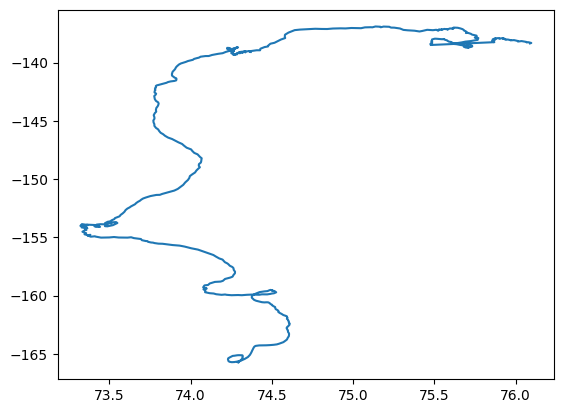

In [15]:
plt.plot(nlat, nlon)

In [16]:
# from IMB:
# final variables to use

# chrono_imb
# sit_imb
# nlat
# nlon

## Import TOPAZ corrected

In [17]:
# filename = f'{irootdir}Leo/TP4b_ML/sit_gAK_2011_2019_01.nc'
# ml_model = 'AK'

In [18]:
filename = f'{irootdir}Leo/TP4_ML/sit_gLSTM3_bk_2011_2019_01.nc'
ml_model = 'LSTM'

In [19]:
from src.data_preparation import load_data

In [20]:
sit_ml, chrono_ml = load_data.load_nc(filename, 'sit_ml', X_only=True)

In [21]:
# Cap negative value at 0 m (while keeping nan)
sit_ml = (sit_ml.where((0<sit_ml), 0)).where(np.isfinite(sit_ml))

In [22]:
sit_ml

<xarray.DataArray 'sit_ml' (time: 3014, y: 329, x: 450)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2019-12-31
  * x          (x) float32 -25.5 -25.38 -25.25 -25.12 ... 30.25 30.38 30.5 30.62
  * y          (y) float32 -17.5 -17.38 -17.25 -17.12 ... 23.12 23.25 23.38 23.5
    latitude   (y, x) float32 62.74 62.83 62.92 63.01 ... 56.49 56.41 56.33
    longitude  (y, x) float32 -100.5 -100.4 -100.3 -100.1 ... 82.73 82.61 82.5

# Import Baseline

In [23]:
from src.modelling import sit_corrected

In [24]:
# ---------------------------------
#       Import all predictions
# ---------------------------------

### LSTM model
irootdir= f'{rootdir}'
ipath = 'Leo/results/lstm_230201-112355/'
ml_name ='LSTM3_bk'

ifile = f'{irootdir}{ipath}'
sitm = sit_corrected.SITCorrected(ifile, name=ml_name, verbose=1)



# ------------------------------------------------
##            Reconstruct SIT values 
# ------------------------------------------------

print('\nReconstructing SIT...')

sitm.reconstruct_sit()
sitm.compute_mean(sit_min=None)   

Config file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_230201-112355/config_LSTM_no_bias_0wk.yaml
Folder: Leo/results/lstm_230201-112355/figures/sit_reconstruct/

Initialisation SIT from LSTM3_bk


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ML prediction .nc file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_230201-112355/ml/ypred_LSTM3_bk.nc

Reconstructing SIT...


In [25]:
sit_bl = sitm.sit_bl

---------------------------

## Localise TOPAZ daily values to buoy location

In [26]:
def get_tindex(chrono_dt_ml, chrono_dt_imb):
    '''
    Get the indexes of IMB in TOPAZ ML-corrected
    
    ref time: chrono_dt_ml : Machine Learning
    imb: from buoy
    '''

    t_idx = []

    for dt in chrono_dt_imb:
        idx = np.where(chrono_dt_ml==dt)[0]
        if idx.size == 1:
#             print(idx[0])
            t_idx.append(int(idx[0]))
        elif idx.size == 0:
#             t_idx.append(None)
            t_idx.append(int(-999))
            
        
    return np.array(t_idx, dtype=int)
#     return t_idx

In [27]:
def get_closest_arr(lat, lon, chrono_dt_imb, sit_tp, chrono_dt_tp):
    '''
    Returns TOPAZ SIT (mean and std) for closest point in space and time
    for one given (lat, lon) point (from IMB buoys)
    
    Parameters:
    -----------
        lat                 :    array of latitude of given points
        lon                 :    array of longitude of given points
        chrono_dt_imb       :    array of datetime object, date of one given point
        sit_tp              :    xarray.DataArray, Sea Ice Thickness ML-corrected from TOPAZ4
        chrono_dt_tp        :    array of datetime object, dates associated to sit_tp
    
    Returns:
    --------
    
        sit                 : array of SIT from Topaz localisation in time and space with buoy
        lats                : array of valid lats
        lons                : array of valid lons
        valid               : valid lat lon points. may be non valid if time index is not found
    
    '''

    # for one given (lat,lon) point
    # get time index tm in TOPAZ chrono
    t_idx = get_tindex(chrono_dt_tp, chrono_dt_imb)
    
    tloc = []
    yloc = []
    xloc = []
    
    lats = []
    lons = []
    valid = []
    
    for tm, lt,ln in zip(t_idx, lat,lon):
        if tm == - 999:
            valid.append(False)
            continue
        
        valid.append(True)
        # localise the closest TOPAZ points for the (lat, lon) point
        # from https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
        # First, find the index of the grid point nearest a specific lat/lon.   
        abslat = np.abs(sit_tp.latitude-lt)
        abslon = np.abs(sit_tp.longitude-ln)
        c = np.maximum(abslon, abslat)
        closest = np.where(c == np.min(c))

        if closest[0].size > 1:  # rare case where one (lat,lon) point is at equal distance of 2 grid points
            # then we just pick the first one
            yloc.append(closest[0][0])
            xloc.append(closest[1][0])
        else:
            yloc.append(closest[0][0])
            xloc.append(closest[1][0])
            
        tloc.append(tm)
        # save valid lat/lon
        lats.append(lt)
        lons.append(ln)
    
    sit = sit_tp.to_numpy()[tloc, yloc, xloc]
    
    
    # print(f'TOPAZ4 global corrected with RF, SIT: {point_ds.mean().data}')
    # print(f'ICESAT , SIT: {dico_ice["Avg_thkns"][index][pi]}')
    
    return sit, np.array(lats), np.array(lons), np.array(valid)


In [28]:
# arrays of datetime objects, to check easily dates
chrono_dt_imb = np.array([dt.date() for dt in chrono_imb.date])
chrono_dt_ml = np.array([dt.date() for dt in chrono_ml.date])

In [29]:
sit_ml_loc, lats, lons, valid_ll = get_closest_arr(nlat, nlon, chrono_dt_imb, sit_ml, chrono_dt_ml)

In [30]:
sit_bl_loc, lats, lons, valid_ll = get_closest_arr(nlat, nlon, chrono_dt_imb, sit_bl, chrono_dt_ml)

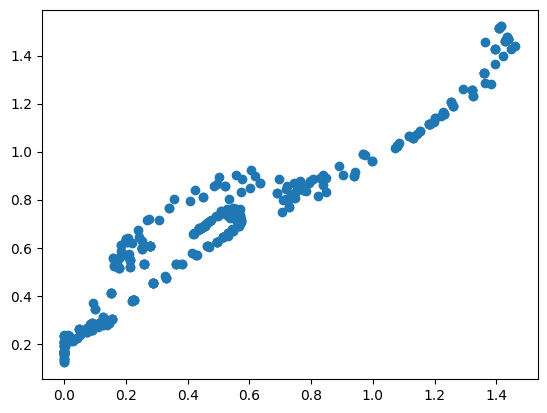

In [43]:
plt.scatter(sit_ml_loc, sit_bl_loc)

## Comparison

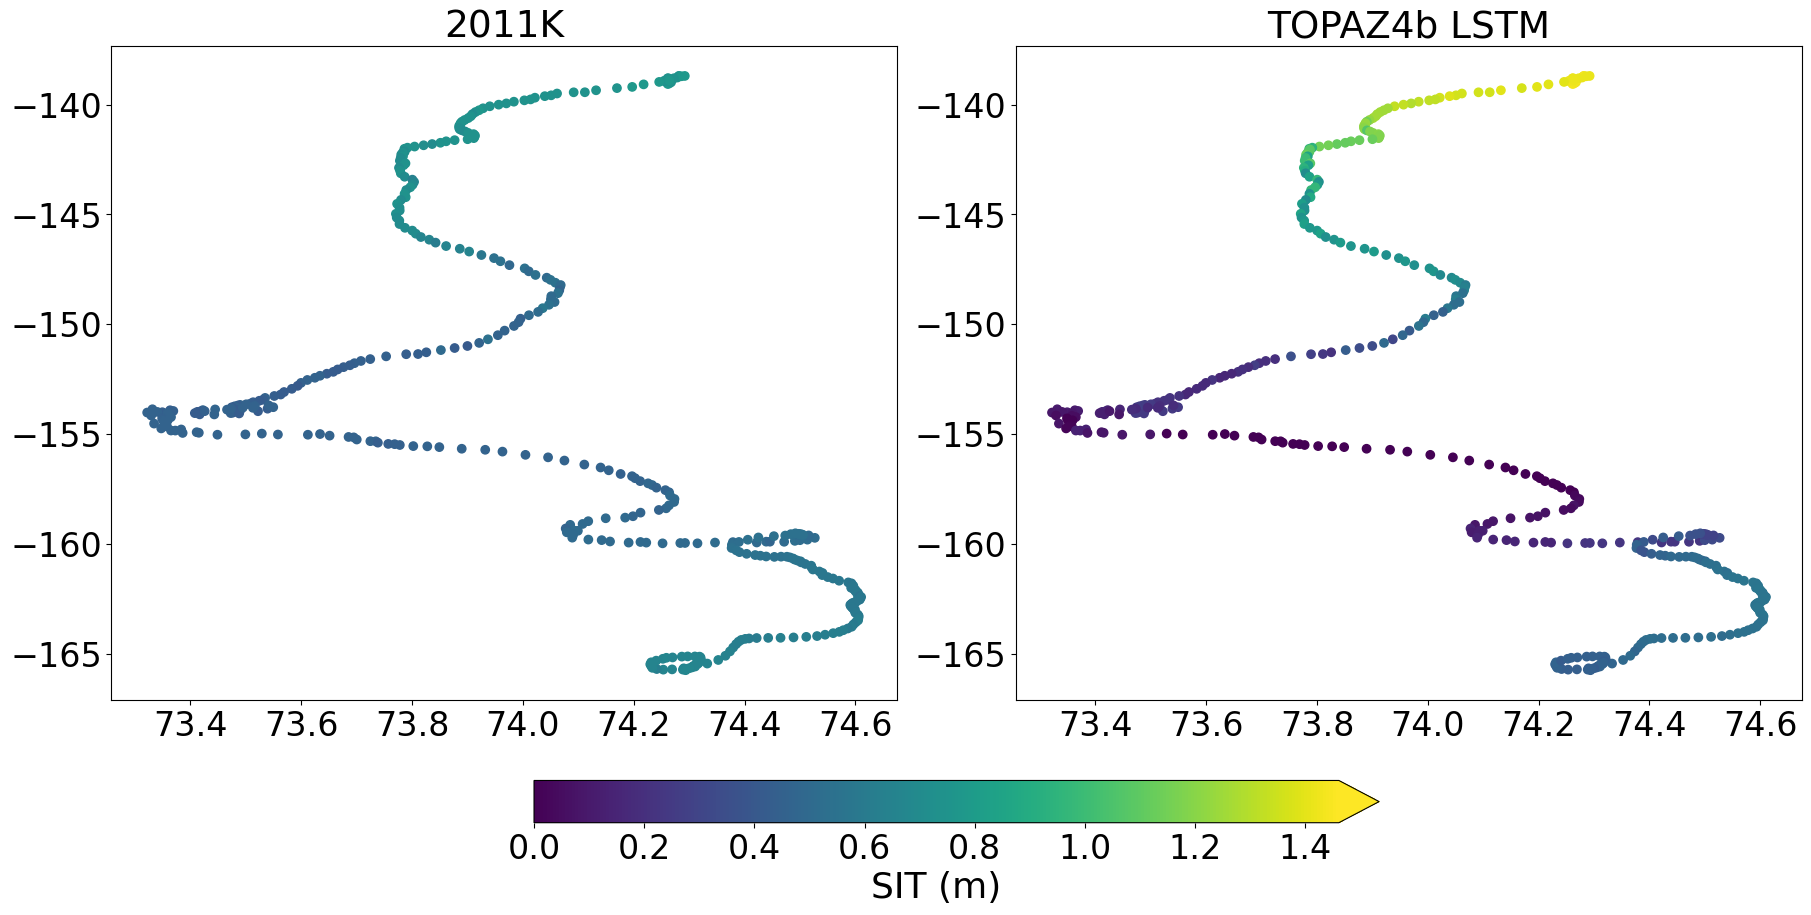

In [41]:
vmin = np.min([np.min(sit_imb[valid_ll]), np.min(sit_ml_loc)])
vmax = np.max([np.max(sit_imb[valid_ll]), np.max(sit_ml_loc)])


fig, axes = plt.subplots(ncols=2, figsize=(9*2, 9), constrained_layout=True)

cs2 = axes[0].scatter(lats, lons, c=sit_imb[valid_ll], vmin=vmin, vmax=vmax)
# axes[0].colorbar()
axes[0].set_title(buoy)

axes[1].scatter(lats, lons, c=sit_ml_loc, vmin=vmin, vmax=vmax)
# axes[1].colorbar()
axes[1].set_title(f'TOPAZ4b {ml_model}');

fig.colorbar(cs2, ax=axes, shrink=0.5, location="bottom", extend='max', label='SIT (m)')

modif_plot.resize(fig, s=24)



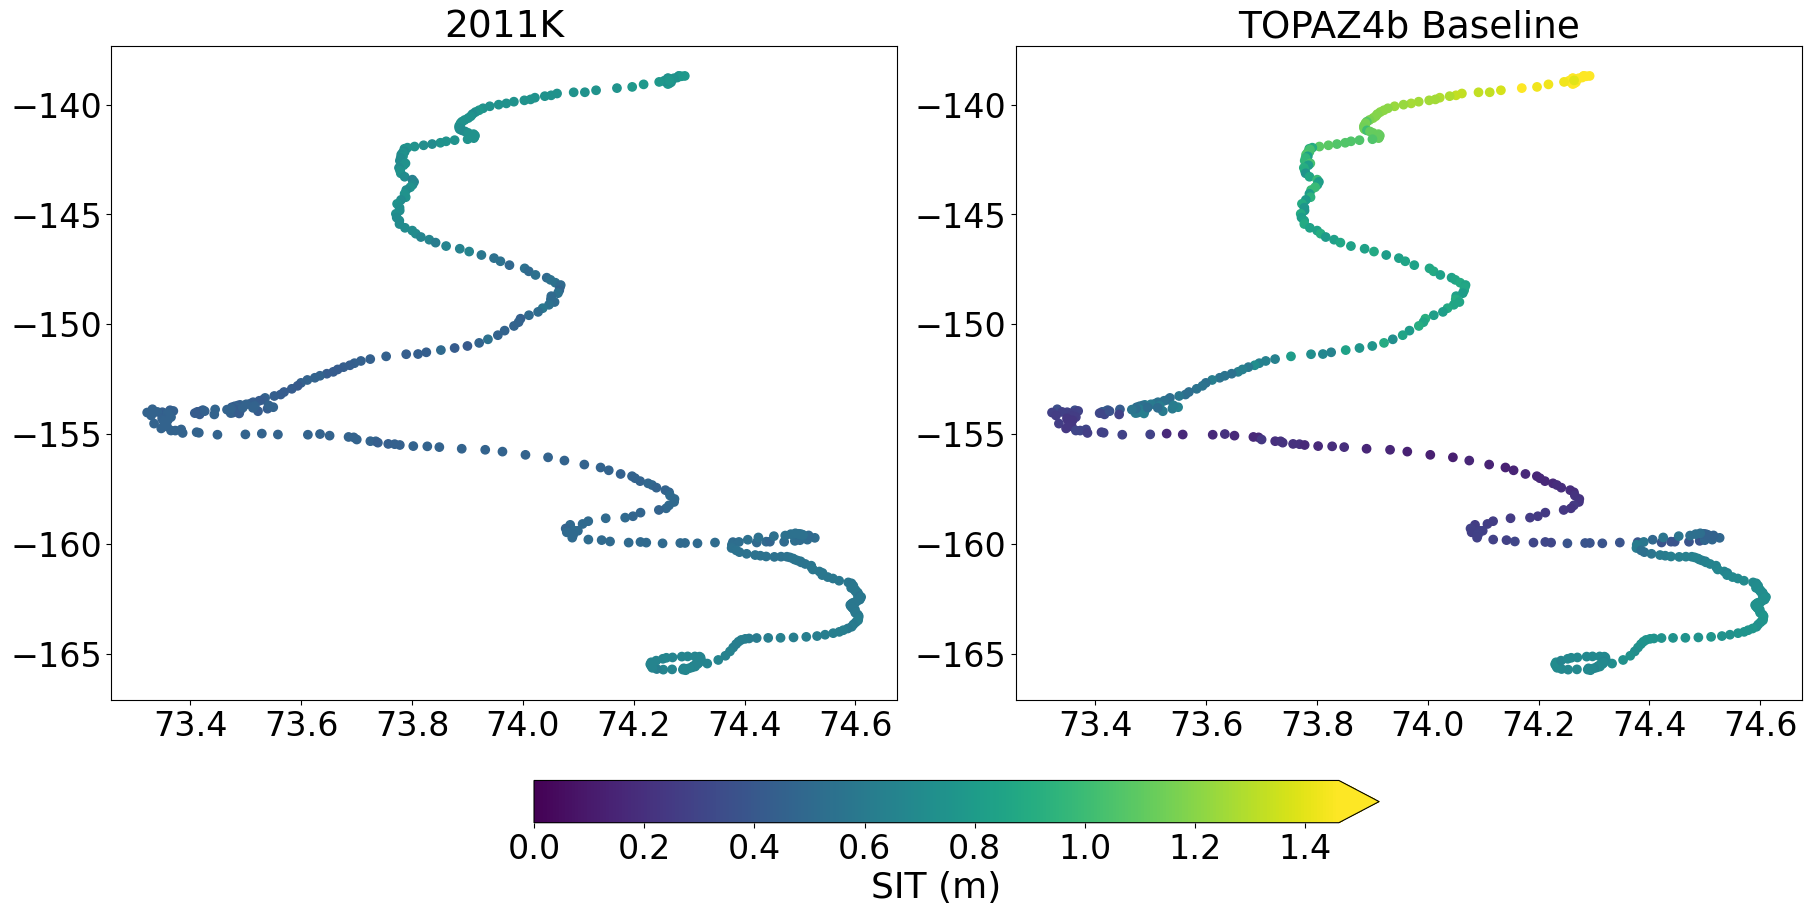

In [42]:
vmin = np.min([np.min(sit_imb[valid_ll]), np.min(sit_ml_loc)])
vmax = np.max([np.max(sit_imb[valid_ll]), np.max(sit_ml_loc)])


fig, axes = plt.subplots(ncols=2, figsize=(9*2, 9), constrained_layout=True)

cs2 = axes[0].scatter(lats, lons, c=sit_imb[valid_ll], vmin=vmin, vmax=vmax)
# axes[0].colorbar()
axes[0].set_title(buoy)

axes[1].scatter(lats, lons, c=sit_bl_loc, vmin=vmin, vmax=vmax)
# axes[1].colorbar()
axes[1].set_title(f'TOPAZ4b Baseline');

fig.colorbar(cs2, ax=axes, shrink=0.5, location="bottom", extend='max', label='SIT (m)')

modif_plot.resize(fig, s=24)



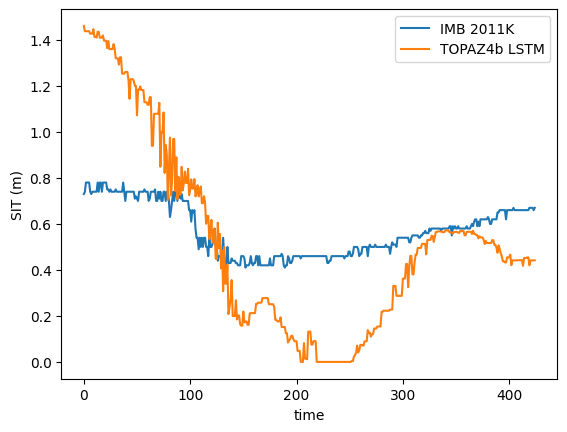

In [27]:
plt.plot(sit_imb[valid_ll].to_numpy(), label=f'IMB {buoy}')
plt.plot(sit_ml_loc, label=f'TOPAZ4b {ml_model}')
plt.ylabel('SIT (m)')
plt.xlabel('time')
plt.legend()

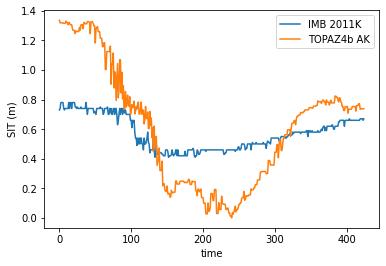

In [375]:
plt.plot(sit_imb[valid_ll].to_numpy(), label=f'IMB {buoy}')
plt.plot(sit_ml_loc, label=f'TOPAZ4b {ml_model}')
plt.ylabel('SIT (m)')
plt.xlabel('time')
plt.legend()

In [29]:
from mpl_toolkits.basemap import Basemap

def double_basemap(lats, lons, sit_obs, sit_tp, suptitle='', odir='', ofile='', savefig=False, showfig=True, **kwargs):
    '''
    Parameters:
    -----------
    
        sit_obs      : Sea Ice Thickness from ICESAT (or other)
        sit_tp       : Sea Ice Thickness from ToPaz
    
    '''
    
    
#     fig = plt.figure(figsize=((1920/103)/1.5,1200/103),dpi=103)
    
    fig, axes = plt.subplots(ncols=2, figsize=(9*2, 9), constrained_layout=True)
    
    m = Basemap(projection='npstere', boundinglat=66, lon_0=0, resolution='l', round=True, ax=axes[0])
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.scatter(lons, lats, c=sit_obs, lw=0, latlon=True, zorder=10, **kwargs)
    # cbar = plt.colorbar(cs)
    # cbar.set_label('{}'.format(label_cb))
    axes[0].set_title('2011K')
    
    
    m2 = Basemap(projection='npstere', boundinglat=66, lon_0=0, resolution='l', round=True, ax=axes[1])
    m2.drawcoastlines()
    m2.drawparallels(np.arange(-80.,81.,20.))
    m2.drawmeridians(np.arange(-180.,181.,20.))
    cs2 = m2.scatter(lons, lats, c=sit_tp, lw=0, latlon=True, zorder=10, **kwargs)
    axes[1].set_title('TOPAZ LSTM')
    
    
    cbar = fig.colorbar(cs2, ax=axes, shrink=0.3, location="bottom", extend='max')
    cbar.set_label('SIT (m)')

    fig.suptitle(suptitle)
    modif_plot.resize(fig, s=24)
    
    if savefig:
        if ofile=='':
            return
        
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()
        
    plt.close()

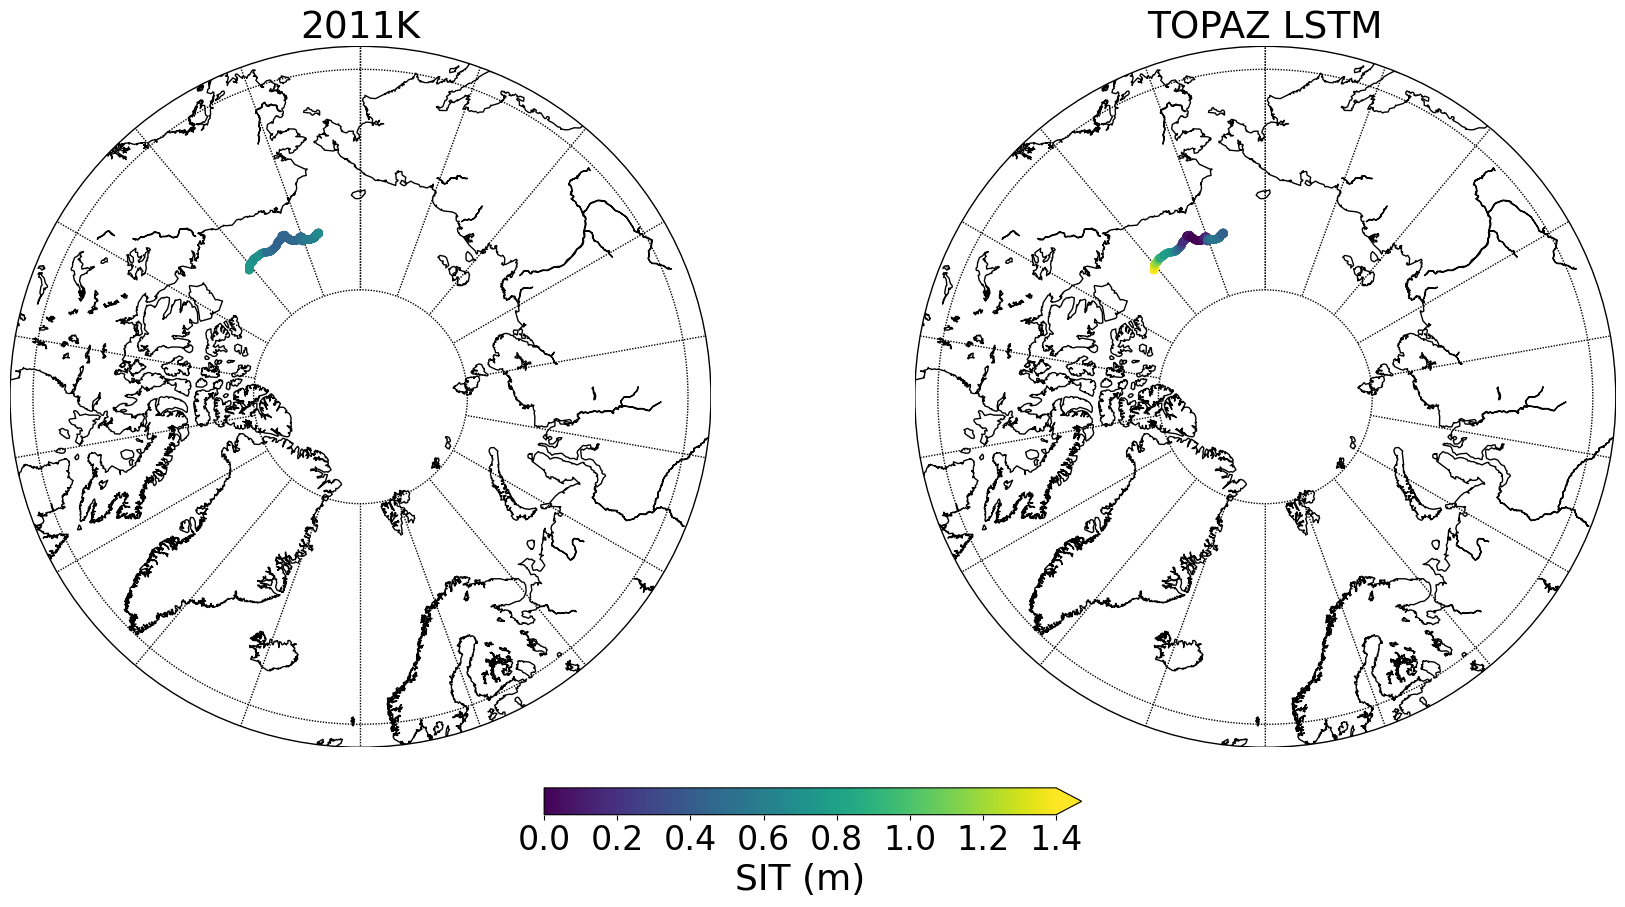

In [32]:
double_basemap(lats, lons, sit_imb[valid_ll], sit_ml_loc, suptitle='', vmin=0, vmax=1.4) # , odir=odir, ofile=ofile, savefig=True)

In [34]:
from mpl_toolkits.basemap import Basemap
from src.utils import npstere_zoom


def double_basemappp(lats, lons, sit_obs, sit_tp, suptitle='', odir='', ofile='', savefig=False, showfig=True, 
                     NpZoom=False, Zoom=[0, 5, 60, 90],**kwargs):
    '''
    Parameters:
    -----------
    
        sit_obs      : Sea Ice Thickness from ICESAT (or other)
        sit_tp       : Sea Ice Thickness from ToPaz
        
        Zoom:   [lonmin, lonmax, latmin, latmax]
    
    '''
    
    
#     fig = plt.figure(figsize=((1920/103)/1.5,1200/103),dpi=103)
    
    fig, axes = plt.subplots(ncols=2, figsize=(9*2, 9), constrained_layout=True)
    
#     m = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[0])
    if NpZoom is False:
        m = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[0])
    else:
        lonmin = Zoom[0]
        lonmax = Zoom[1]
        latmin = Zoom[2]
        latmax = Zoom[3]
        m = npstere_zoom.mzoom_subplot(axes[0], lonmin, lonmax, latmin, latmax)
    
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.scatter(lons, lats, c=sit_obs, lw=0, latlon=True, zorder=10, **kwargs)
    # cbar = plt.colorbar(cs)
    # cbar.set_label('{}'.format(label_cb))
    axes[0].set_title('2011K')
    
    
#     m2 = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[1])
    
    if NpZoom is False:
        m2 = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[1])
    else:
        lonmin = Zoom[0]
        lonmax = Zoom[1]
        latmin = Zoom[2]
        latmax = Zoom[3]
#         print(lonmin, lonmax, latmin, latmax)
        m2 = npstere_zoom.mzoom_subplot(axes[1], lonmin, lonmax, latmin, latmax)
    
    
    m2.drawcoastlines()
    m2.drawparallels(np.arange(-80.,81.,20.))
    m2.drawmeridians(np.arange(-180.,181.,20.))
    cs2 = m2.scatter(lons, lats, c=sit_tp, lw=0, latlon=True, zorder=10, **kwargs)
#     axes[1].set_title('TOPAZ LSTM')
    axes[1].set_title('TOPAZ Baseline')
    
    
    
    cbar = fig.colorbar(cs2, ax=axes, shrink=0.3, location="bottom", extend='max')
    cbar.set_label('SIT (m)')

    fig.suptitle(suptitle)
    modif_plot.resize(fig, s=24)
    
    if savefig:
        if ofile=='':
            return
        
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()
        
    plt.close()

In [47]:
from mpl_toolkits.basemap import Basemap
from src.utils import npstere_zoom


def four_basemap(lats, lons, sit_obs, sit_tp, sit_bl, sit_diff, 
                 suptitle='', odir='', ofile='', savefig=False, showfig=True, 
                     NpZoom=False, Zoom=[0, 5, 60, 90],**kwargs):
    '''
    Parameters:
    -----------
    
        sit_obs      : Sea Ice Thickness from ICESAT (or other)
        sit_tp       : Sea Ice Thickness from ToPaz
        
        Zoom:   [lonmin, lonmax, latmin, latmax]
    
    '''
    
    
#     fig = plt.figure(figsize=((1920/103)/1.5,1200/103),dpi=103)
    
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9*2, 9*2), constrained_layout=True)
    
#     m = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[0])
    if NpZoom is False:
        m = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[0][0])
    else:
        lonmin = Zoom[0]
        lonmax = Zoom[1]
        latmin = Zoom[2]
        latmax = Zoom[3]
        m = npstere_zoom.mzoom_subplot(axes[0][0], lonmin, lonmax, latmin, latmax)
    
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.scatter(lons, lats, c=sit_obs, lw=0, latlon=True, zorder=10, **kwargs)
    # cbar = plt.colorbar(cs)
    # cbar.set_label('{}'.format(label_cb))
    axes[0][0].set_title('2011K')
    
    
#     m2 = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[1])
    
    if NpZoom is False:
        m2 = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[0][1])
    else:
        lonmin = Zoom[0]
        lonmax = Zoom[1]
        latmin = Zoom[2]
        latmax = Zoom[3]
#         print(lonmin, lonmax, latmin, latmax)
        m2 = npstere_zoom.mzoom_subplot(axes[0][1], lonmin, lonmax, latmin, latmax)
    
    
    m2.drawcoastlines()
    m2.drawparallels(np.arange(-80.,81.,20.))
    m2.drawmeridians(np.arange(-180.,181.,20.))
    cs2 = m2.scatter(lons, lats, c=sit_tp, lw=0, latlon=True, zorder=10, **kwargs)
    axes[0][1].set_title('TOPAZ LSTM')
    
    
    
    if NpZoom is False:
        m3 = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[1][0])
    else:
        lonmin = Zoom[0]
        lonmax = Zoom[1]
        latmin = Zoom[2]
        latmax = Zoom[3]
#         print(lonmin, lonmax, latmin, latmax)
        m3 = npstere_zoom.mzoom_subplot(axes[1][0], lonmin, lonmax, latmin, latmax)
    
    
    m3.drawcoastlines()
    m3.drawparallels(np.arange(-80.,81.,20.))
    m3.drawmeridians(np.arange(-180.,181.,20.))
    cs3 = m3.scatter(lons, lats, c=sit_tp, lw=0, latlon=True, zorder=10, **kwargs)
    axes[1][0].set_title('TOPAZ Baseline')
    
    
    if NpZoom is False:
        m4 = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[1][1])
    else:
        lonmin = Zoom[0]
        lonmax = Zoom[1]
        latmin = Zoom[2]
        latmax = Zoom[3]
#         print(lonmin, lonmax, latmin, latmax)
        m4 = npstere_zoom.mzoom_subplot(axes[1][1], lonmin, lonmax, latmin, latmax)
    
    
    m4.drawcoastlines()
    m4.drawparallels(np.arange(-80.,81.,20.))
    m4.drawmeridians(np.arange(-180.,181.,20.))
    cs4 = m4.scatter(lons, lats, c=sit_diff, lw=0, latlon=True, zorder=10, vmin=-.5, vmax=.5, cmap=plt.get_cmap('bwr_r'))
    axes[1][1].set_title('Baseline - LSTM')

    
    
    # cmap 1
    cbar = fig.colorbar(cs2, ax=axes[0], shrink=0.3, location="bottom", extend='max')
    cbar.set_label('SIT (m)')

    # cmap diff
    cbar2 = fig.colorbar(cs4, ax=axes[1], shrink=0.3, location="bottom", extend='both')
#     cbar2.ax.set_xticklabels(['la', '0', 'tg'])
    cbar2.set_label('SIT Baseline - LSTM (m)')
    
    
    fig.suptitle(suptitle)
    modif_plot.resize(fig, s=24)
    
    if savefig:
        if ofile=='':
            return
        
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()
        
    plt.close()

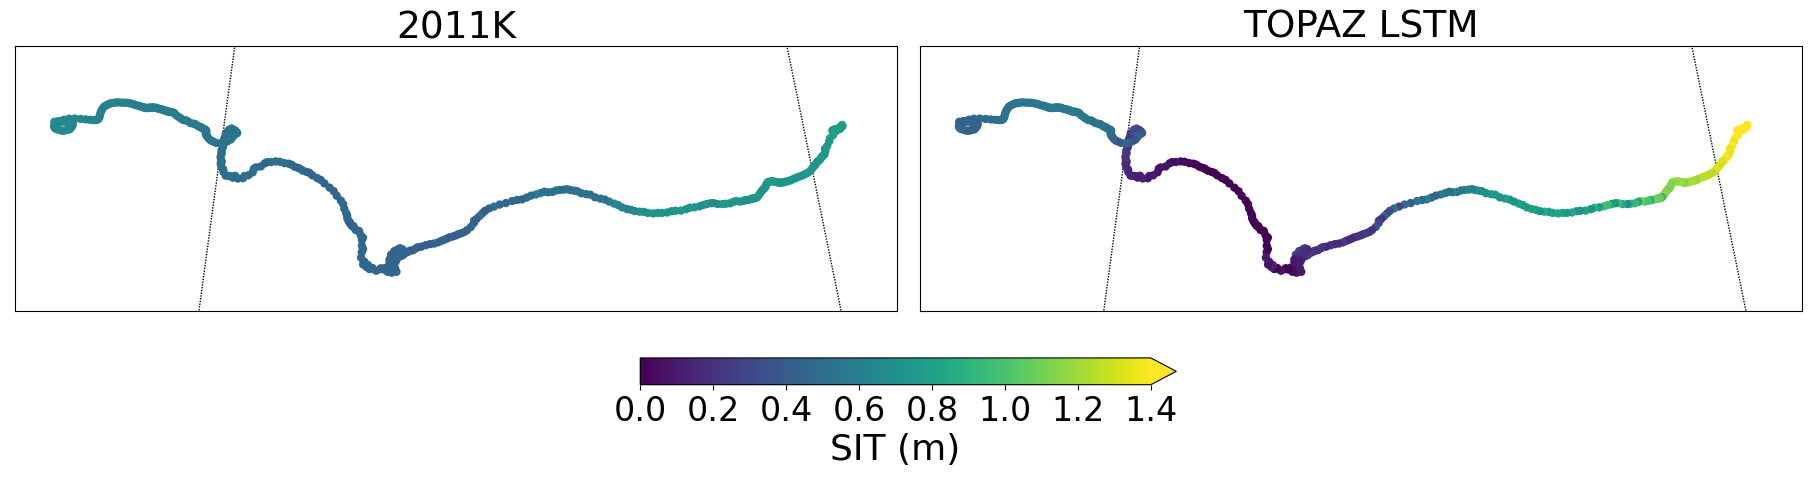

In [32]:
double_basemappp(lats, lons, sit_imb[valid_ll], sit_ml_loc, suptitle='', vmin=0, vmax=1.4,
                NpZoom=True, Zoom=[-166, -138, 73, 75]) # , odir=odir, ofile=ofile, savefig=True)

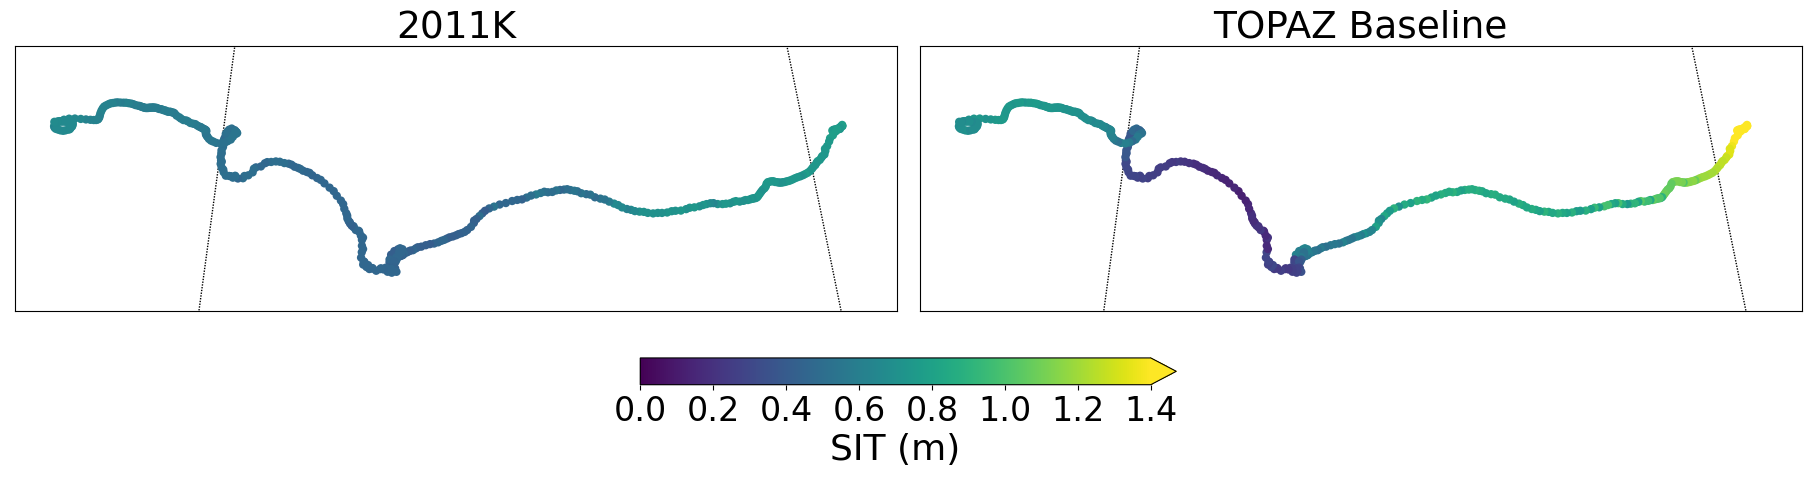

In [35]:
double_basemappp(lats, lons, sit_imb[valid_ll], sit_bl_loc, suptitle='', vmin=0, vmax=1.4,
                NpZoom=True, Zoom=[-166, -138, 73, 75]) # , odir=odir, ofile=ofile, savefig=True)

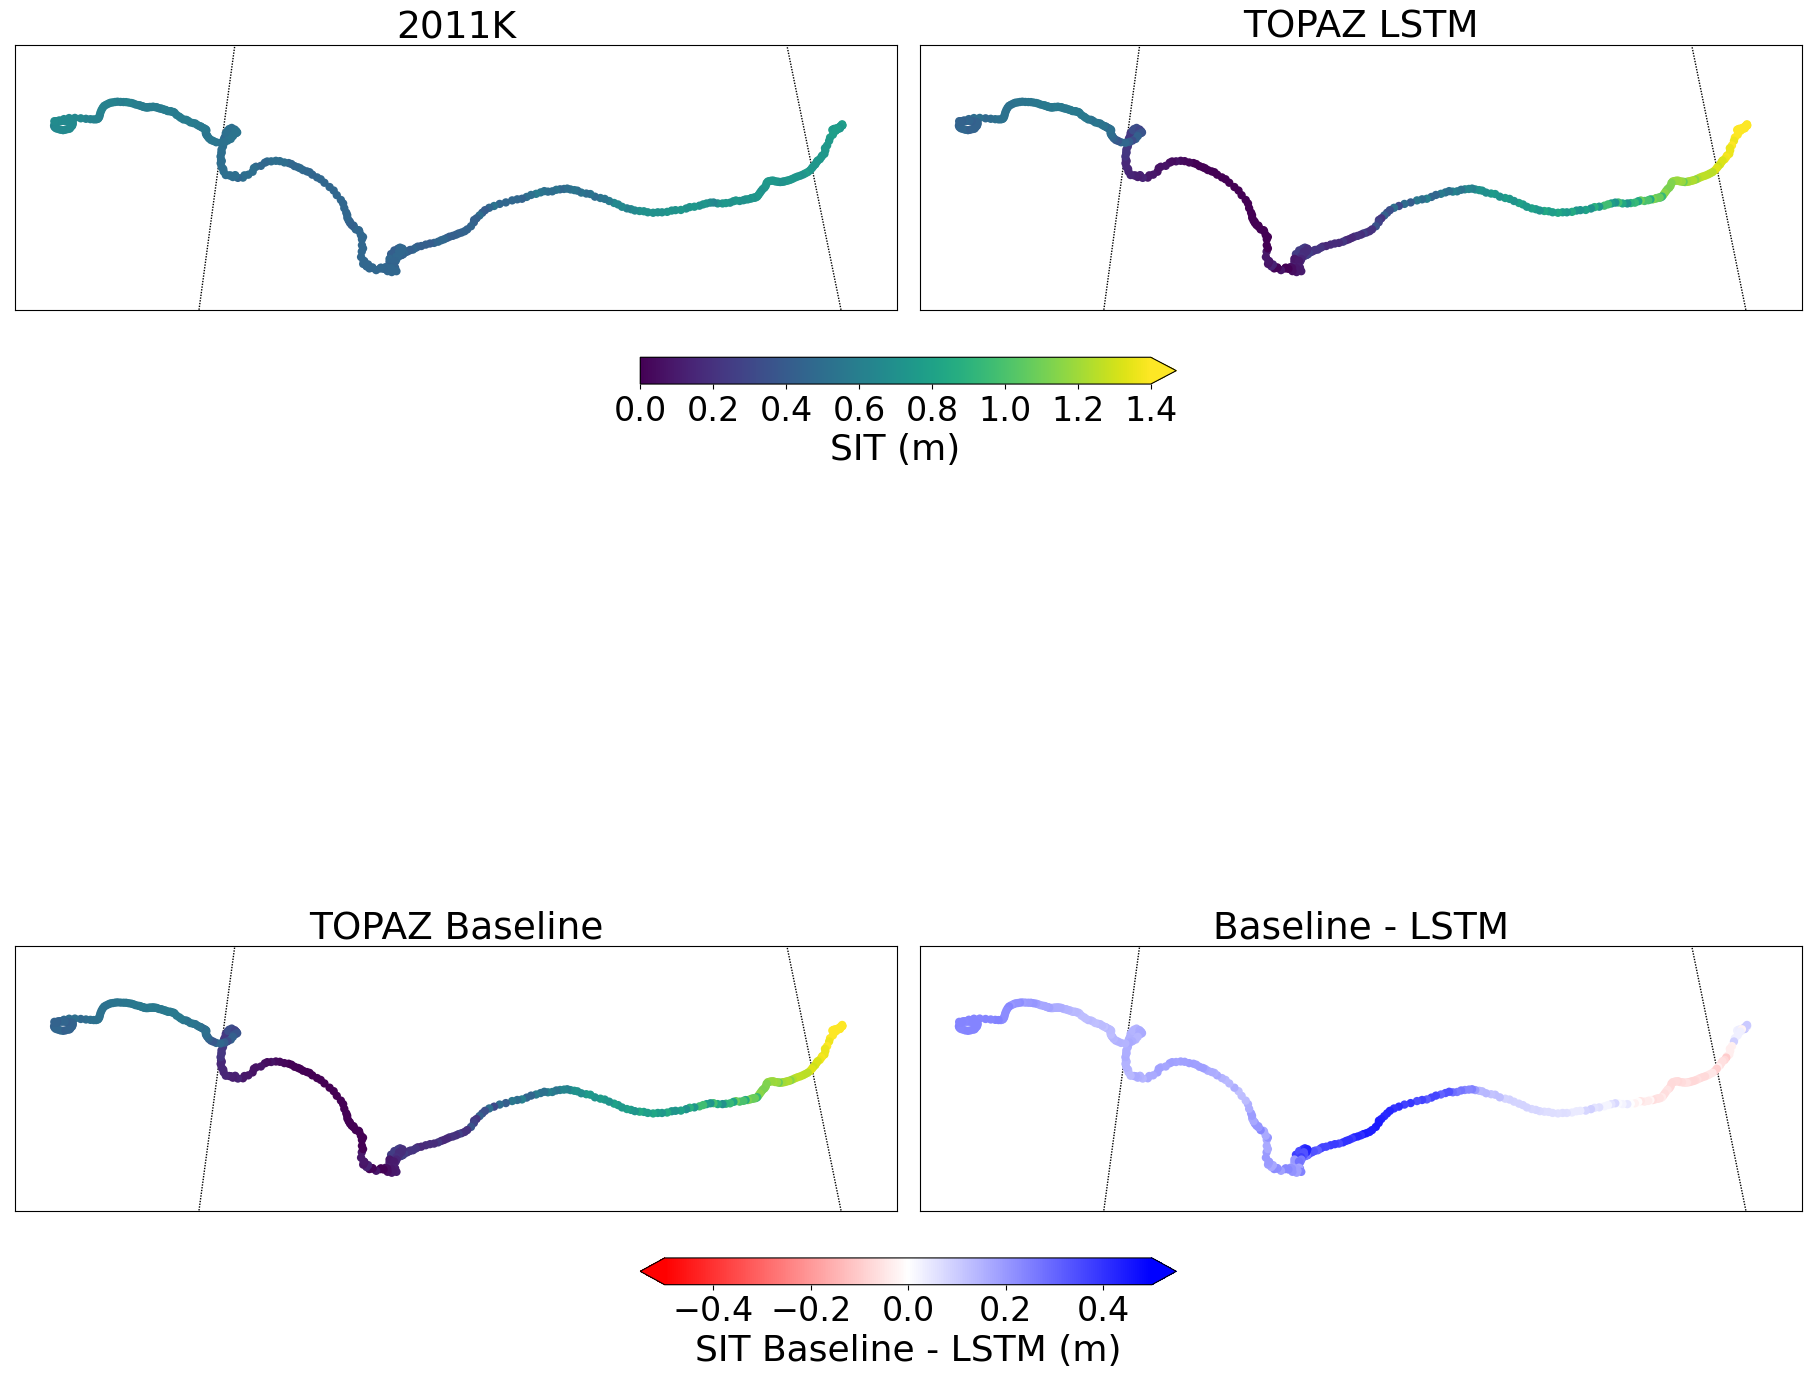

In [48]:
four_basemap(lats, lons, sit_imb[valid_ll], sit_ml_loc, sit_bl_loc, sit_bl_loc -sit_ml_loc,
             suptitle='', vmin=0, vmax=1.4,
                NpZoom=True, Zoom=[-166, -138, 73, 75]) # , odir=odir, ofile=ofile, savefig=True)